In [63]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import recall_score, roc_auc_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, fbeta_score
import optuna
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import warnings

In [64]:
def evaluation(model, true, pred):
    print('F1_score', f1_score(true, model.predict(pred)))
        
    print('')
    tn, fp, fn, tp = confusion_matrix(true, model.predict(pred)).ravel()
    print(tn, 'раз модель правильно определила, что затора не будет')
    print(fp, 'раз модель неправильно определила, что затор будет')
    print(fn, 'раз из',true.value_counts()[1],'модель неправильно определила, что затора не будет')
    print(tp, 'раз из',true.value_counts()[1],'модель правильно определила, что затор будет')

In [65]:
random_state = 33 
test_size = 0.20

In [66]:
df = pd.read_csv('df.csv')
X = df.drop(['ij_1'], axis=1)
y = df['ij_1']

In [67]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

In [68]:
y_train_valid.sum()

18.0

In [69]:
y_test.sum()

5.0

In [70]:
best_params_LogReg = {'scaler': 'RobustScaler', 
                      'logreg__C': 637.6174168530237, 
                      'logreg__penalty': 'l1', 
                      'logreg__solver': 'liblinear', 
                      'k_neighbors': 7, 
                      'param_threshold': 70}

In [71]:
if best_params_LogReg['scaler'] == 'StandardScaler':
    best_scaler = StandardScaler()
elif best_params_LogReg['scaler'] == 'MinMaxScaler':
    best_scaler = MinMaxScaler()
else:
    best_scaler = RobustScaler()

In [72]:
best_model_LogReg = Pipeline([
    ('scaler', best_scaler),
    ('logreg', LogisticRegression(
        C=best_params_LogReg['logreg__C'],
        penalty=best_params_LogReg['logreg__penalty'],
        solver=best_params_LogReg['logreg__solver'],
        max_iter=10000))])   

In [73]:
oversample = SMOTE(random_state=random_state, k_neighbors=best_params_LogReg['k_neighbors'])
X_train_oversampled_fin, y_train_oversampled_fin = oversample.fit_resample(X_train_valid, y_train_valid)
best_model_LogReg.fit(X_train_oversampled_fin, y_train_oversampled_fin)

Pipeline(steps=[('scaler', RobustScaler()),
                ('logreg',
                 LogisticRegression(C=637.6174168530237, max_iter=10000,
                                    penalty='l1', solver='liblinear'))])

In [74]:
evaluation(best_model_LogReg, y_test, X_test)

F1_score 0.8000000000000002

227 раз модель правильно определила, что затора не будет
1 раз модель неправильно определила, что затор будет
1 раз из 5 модель неправильно определила, что затора не будет
4 раз из 5 модель правильно определила, что затор будет


In [75]:
tn, fp, fn, tp = confusion_matrix(y_test, (best_model_LogReg.predict_proba(X_test)[:, 1] > best_params_LogReg['param_threshold']/100).astype(int)).ravel()
print(tn, 'раз модель правильно определила, что затора не будет')
print(fp, 'раз модель неправильно определила, что затор будет')
print(fn, 'раз из',y_test.value_counts()[1],'модель неправильно определила, что затора не будет')
print(tp, 'раз из',y_test.value_counts()[1],'модель правильно определила, что затор будет')
print('f1_score =', f1_score(y_test, (best_model_LogReg.predict_proba(X_test)[:, 1] > best_params_LogReg['param_threshold']/100).astype(int)))

228 раз модель правильно определила, что затора не будет
0 раз модель неправильно определила, что затор будет
1 раз из 5 модель неправильно определила, что затора не будет
4 раз из 5 модель правильно определила, что затор будет
f1_score = 0.888888888888889


In [76]:
roc_auc_score(y_test, (best_model_LogReg.predict_proba(X_test)[:, 1] > best_params_LogReg['param_threshold']/100).astype(int))

0.9

In [77]:
def EDI_SEDI(model, X, y):
    tn, fp, fn, tp = confusion_matrix(y, model.predict(X)).ravel()
    H = tp / (tp + fn) #Probability of detection (hit rate) = recall
    F = fp / (tn + fp) #Probability of false detection (false alarm rate)
    EDI = (np.log(F) - np.log(H) + np.log(1 - H) - np.log(1 - F)) / (np.log(F) + np.log(H)+ np.log(1 - H) + np.log(1 - F))
    SEDI = (np.log(F) - np.log(H)) / (np.log(F) + np.log(H))
    return EDI, SEDI

In [78]:
EDI_SEDI(best_model_LogReg, X_test, y_test)

(0.9373715778803806, 0.9210459165165163)

In [79]:
#background_test = shap.maskers.Independent(X_test, max_samples=3000)
#background_test.shape

In [80]:
explainer = shap.LinearExplainer(best_model_LogReg['logreg'], best_model_LogReg['scaler'].transform(X_train_oversampled_fin), feature_names=list(X_test.columns), random_state=random_state)
shap_values_test = explainer(best_model_LogReg['scaler'].transform(X_test))

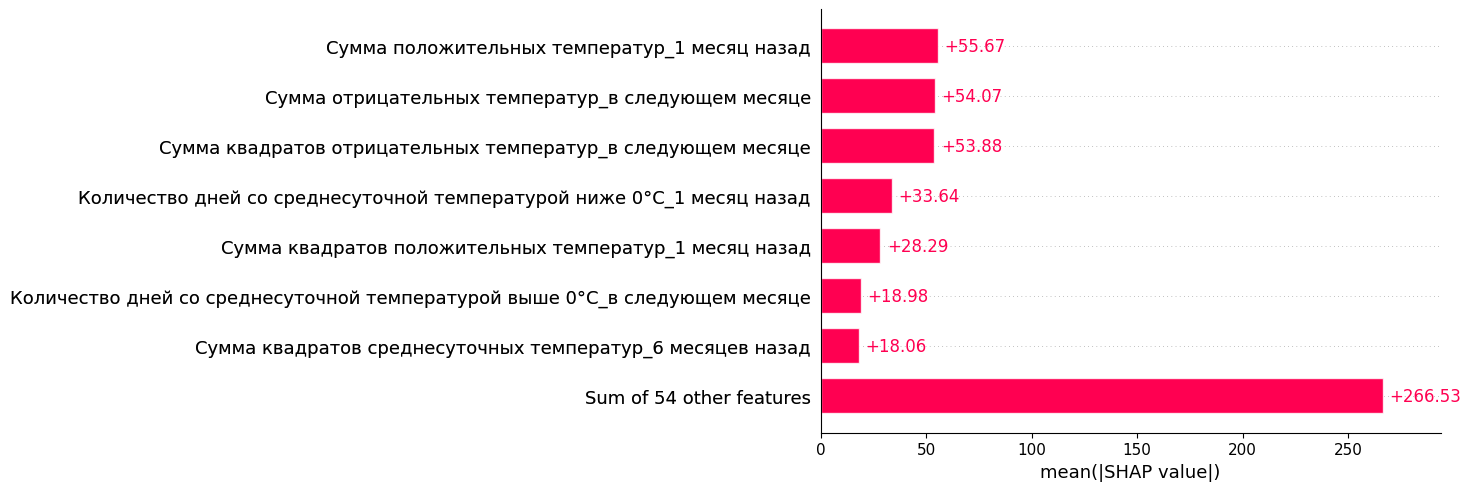

In [81]:
shap.plots.bar(shap_values_test, max_display=8)

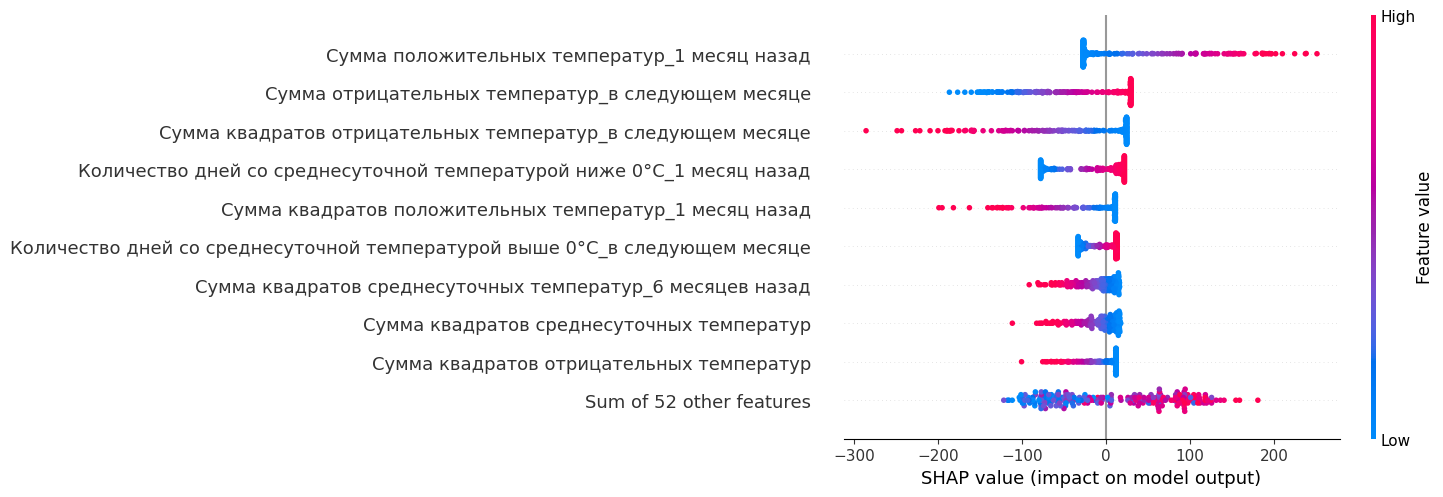

In [82]:
shap.plots.beeswarm(shap_values_test)

In [111]:
i_ = []
f_ = []
for i in range(1, 100):
    i_.append(i)
    f_.append(f1_score(y_test, (best_model_LogReg.predict_proba(X_test)[:, 1] > i/100).astype(int)))
    

In [113]:
f_

[0.5714285714285714,
 0.6153846153846154,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.7272727272727272,
 0.7272727272727272,
 0.7272727272727272,
 0.7272727272727272,
 0.7272727272727272,
 0.7272727272727272,
 0.7272727272727272,
 0.7272727272727272,
 0.7272727272727272,
 0.7272727272727272,
 0.7272727272727272,
 0.7272727272727272,
 0.7272727272727272,
 0.7272727272727272,
 0.7272727272727272,
 0.7272727272727272,
 0.7272727272727272,
 0.7272727272727272,
 0.7272727272727272,
 0.7272727272727272,
 0.7272727272727272,
 0.7272727272727272,
 0.7272727272727272,
 0.7272727272727272,
 0.7272727272727272,
 0.7272727272727272,
 0.7272727272727272,
 0.7272727272727272,
 0.7272727272727272,
 0.7272727272727272,
 0.7272727272727272,
 0.7272727272727272,
 0.7272727272727272,
 0.7272727272727272,
 0.7272727272727272,
 0.7272727272727272,
 0.7272727272727272,
 0.7272727272727272,
 0.7272727272727272,
 0.7272727272727272,
 0.7272727272727272,
 0.7272727272

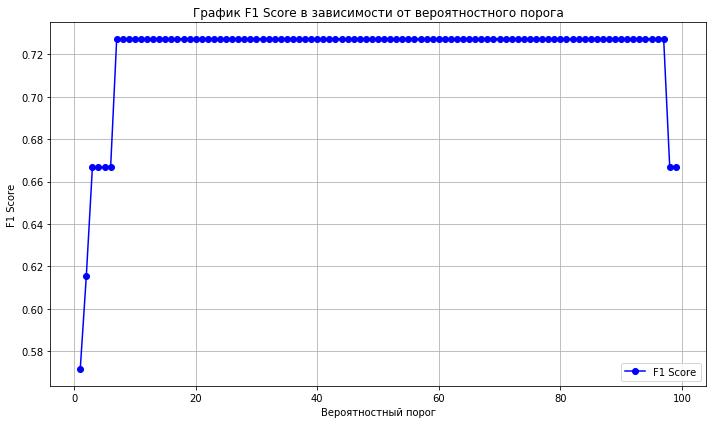

In [115]:
plt.figure(figsize=(10, 6))
plt.plot(i_, f_, marker='o', linestyle='-', color='b', label='F1 Score')
plt.title('График F1 Score в зависимости от вероятностного порога')
plt.xlabel('Вероятностный порог')
plt.ylabel('F1 Score')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()